In [1]:
## AKB: trying this Nov 2025

## This version: Dallas grocery stores, using geodesic distance vs. walking distance

In [2]:
# from google.colab import drive, files
# drive.mount('/content/drive')
# pathname = "/content/drive/Shared with me/TDA for Resource Access/"
# import sys
# sys.path.append(pathname)
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [3]:
# !pip install geopandas

In [4]:
# !pip install gudhi

In [5]:
need_to_create_zip_file = False
if need_to_create_zip_file:
    import geopandas as gpd

    # Need to get zip codes
    zipcode_fname = '~/Dropbox/MyProjects_Current/VoterListMgmt/SpatialData/ZipCodes/tl_2024_us_zcta520/tl_2024_us_zcta520.shp'
    zipUSA = gpd.read_file(zipcode_fname)

    cnty_fname = '~/Dropbox/MyProjects_Current/VoterListMgmt/SpatialData/tl_2023_us_county/tl_2023_us_county.shp'
    cntyUSA = gpd.read_file(cnty_fname)

    # Keep only the desired county
    statefp = '48'
    countyfp = '113'

    cntyUSA = cntyUSA[cntyUSA['STATEFP']==statefp]
    cntyUSA = cntyUSA[cntyUSA['COUNTYFP']==countyfp]

    zipDallas = zipUSA.overlay(cntyUSA,how='intersection')
    zipDallas.to_file('./Dallas/dal_tx_zip.shp')
else:
    zip_fname = './Dallas/dal_tx_zip.shp'

Jerry's modified version of Gudhi plotting

In [6]:
# This file is part of the Gudhi Library - https://gudhi.inria.fr/ - which is released under MIT.
# See file LICENSE or go to https://gudhi.inria.fr/licensing/ for full license details.
# Author(s):       Vincent Rouvreau, Bertrand Michel
#
# Copyright (C) 2016 Inria
#
# Modification(s):
#   - 2020/02 Theo Lacombe: Added more options for improved rendering and more flexibility.
#   - YYYY/MM Author: Description of the modification

from os import path
from math import isfinite
import numpy as np
from functools import lru_cache

__author__ = "Vincent Rouvreau, Bertrand Michel, Theo Lacombe"
__copyright__ = "Copyright (C) 2016 Inria"
__license__ = "MIT"

_gudhi_matplotlib_use_tex = True

def __min_birth_max_death(persistence, band=0.0):
    """This function returns (min_birth, max_death) from the persistence.

    :param persistence: The persistence to plot.
    :type persistence: list of tuples(dimension, tuple(birth, death)).
    :param band: band
    :type band: float.
    :returns: (float, float) -- (min_birth, max_death).
    """
    # Look for minimum birth date and maximum death date for plot optimisation
    max_death = 0
    min_birth = persistence[0][1][0]
    for interval in reversed(persistence):
        if float(interval[1][1]) != float("inf"):
            if float(interval[1][1]) > max_death:
                max_death = float(interval[1][1])
        if float(interval[1][0]) > max_death:
            max_death = float(interval[1][0])
        if float(interval[1][0]) < min_birth:
            min_birth = float(interval[1][0])
    if band > 0.0:
        max_death += band
    return (min_birth, max_death)


def _array_handler(a):
    '''
    :param a: if array, assumes it is a (n x 2) np.array and return a
                persistence-compatible list (padding with 0), so that the
                plot can be performed seamlessly.
    '''
    if isinstance(a[0][1], np.float64) or isinstance(a[0][1], float):
        return [[0, x] for x in a]
    else:
        return a

@lru_cache(maxsize=1)
def _matplotlib_can_use_tex():
    """This function returns True if matplotlib can deal with LaTeX, False otherwise.
    The returned value is cached.
    """
    try:
        from matplotlib import checkdep_usetex
        return checkdep_usetex(True)
    except ImportError:
        print("This function is not available, you may be missing matplotlib.")

def plot_persistence_diagram(
    persistence=[],
    alpha=0.6,
    band=0.0,
    max_intervals=1000,
    inf_delta=0.1,
    legend=False,
    colormap=None,
    axes=None,
    fontsize=16,
    greyblock=True,
    use_fixed_max = True
):
    """This function plots the persistence diagram from persistence values
    list, a np.array of shape (N x 2) representing a diagram in a single
    homology dimension, or from a `persistence diagram <fileformats.html#persistence-diagram>`_ file`.

    :param persistence: Persistence intervals values list. Can be grouped by dimension or not.
    :type persistence: an array of (dimension, array of (birth, death)) or an array of (birth, death).
    :param alpha: plot transparency value (0.0 transparent through 1.0
        opaque - default is 0.6).
    :type alpha: float.
    :param band: band (not displayed if :math:`\leq` 0. - default is 0.)
    :type band: float.
    :param max_intervals: maximal number of intervals to display.
        Selected intervals are those with the longest life time. Set it
        to 0 to see all. Default value is 1000.
    :type max_intervals: int.
    :param inf_delta: Infinity is placed at :code:`((max_death - min_birth) x
        inf_delta)` above :code:`max_death` value. A reasonable value is
        between 0.05 and 0.5 - default is 0.1.
    :type inf_delta: float.
    :param legend: Display the dimension color legend (default is False).
    :type legend: boolean.
    :param colormap: A matplotlib-like qualitative colormaps. Default is None
        which means :code:`matplotlib.cm.Set1.colors`.
    :type colormap: tuple of colors (3-tuple of float between 0. and 1.).
    :param axes: A matplotlib-like subplot axes. If None, the plot is drawn on
        a new set of axes.
    :type axes: `matplotlib.axes.Axes`
    :param fontsize: Fontsize to use in axis.
    :type fontsize: int
    :param greyblock: if we want to plot a grey patch on the lower half plane for nicer rendering. Default True.
    :type greyblock: boolean
    :returns: (`matplotlib.axes.Axes`): The axes on which the plot was drawn.
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        from matplotlib import rc
        if _gudhi_matplotlib_use_tex and _matplotlib_can_use_tex():
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        else:
            plt.rc('text', usetex=False)
            plt.rc('font', family='DejaVu Sans')

        persistence = _array_handler(persistence)

        if max_intervals > 0 and max_intervals < len(persistence):
            # Sort by life time, then takes only the max_intervals elements
            persistence = sorted(
                persistence,
                key=lambda life_time: life_time[1][1] - life_time[1][0],
                reverse=True,
            )[:max_intervals]

        if colormap == None:
            colormap = plt.cm.Set1.colors
        if axes == None:
            fig, axes = plt.subplots(1, 1)

        (min_birth, max_death) = __min_birth_max_death(persistence, band)
        
        if False:
            print('checking min birth, max death')
            print([min_birth, max_death])
        
        delta = (max_death - min_birth) * inf_delta
        # Replace infinity values with max_death + delta for diagram to be more
        # readable
        if use_fixed_max:
            infinity = 7942/60 + delta
            axis_end = 7942/60 + delta / 2
        else:
            infinity = max_death + delta
            axis_end = max_death + delta / 2         
            
        axis_start = min_birth - delta

        if use_fixed_max:
            axis_start = 0

        if False:
            print('After "use_fixed_max" lines') 
            print([axis_start, axis_end])
        
        # bootstrap band
        if band > 0.0:
            x = np.linspace(axis_start, infinity, 1000)
            axes.fill_between(x, x, x + band, alpha=alpha, facecolor="red")
        # lower diag patch
        if greyblock:
            axes.add_patch(mpatches.Polygon([[axis_start, axis_start], [axis_end, axis_start], [axis_end, axis_end]], fill=True, color='lightgrey'))
        # Draw points in loop
        pts_at_infty = False  # Records presence of pts at infty
        for interval in reversed(persistence):
            if float(interval[1][1]) != float("inf"):
                # Finite death case
                if interval[0]==0:
                    axes.scatter(
                        interval[1][0],
                        interval[1][1],
                        alpha=alpha,
                        color=colormap[interval[0]],
                    )
                else:
                    axes.scatter(
                        interval[1][0],
                        interval[1][1],
                        alpha=alpha,
                        color=colormap[interval[0]],
                        marker = 'X'
                    )
            else:
                pts_at_infty = True
                # Infinite death case for diagram to be nicer
                if interval[0]==0:
                    axes.scatter(
                        interval[1][0], infinity, alpha=alpha, color=colormap[interval[0]]
                    )
                else:
                    axes.scatter(
                        interval[1][0], infinity, alpha=alpha, color=colormap[interval[0]], marker = 'X'
                    )
        if pts_at_infty:
            # infinity line and text
            axes.plot([axis_start, axis_end], [axis_start, axis_end], linewidth=1.0, color="k")
            axes.plot([axis_start, axis_end], [infinity, infinity], linewidth=1.0, color="k", alpha=alpha)
            # Infinity label
            yt = axes.get_yticks()
            yt = yt[np.where(yt < axis_end)] # to avoid ploting ticklabel higher than infinity
            yt = np.append(yt, infinity)
            ytl = ["%.0f" % e for e in yt]  # to avoid float precision error
            ytl[-1] = r'$+\infty$'
            axes.set_yticks(yt)
            axes.set_yticklabels(ytl)

        if legend:
            dimensions = list(set(item[0] for item in persistence))
            axes.legend(
                handles=[
                    mpatches.Patch(color=colormap[dim], label=str(dim) + "D homology class")
                    for dim in dimensions
                ]
            )

        axes.set_xlabel("Birth", fontsize=fontsize)
        axes.set_ylabel("Death", fontsize=fontsize)
        axes.set_title("Persistence diagram", fontsize=fontsize)
        # Ends plot on infinity value and starts a little bit before min_birth

        print([axis_start, axis_end])
        axes.axis([axis_start, axis_end, axis_start, infinity + delta/2])
        return axes

    except ImportError:
        print("This function is not available, you may be missing matplotlib.")

<>:91: SyntaxWarning: invalid escape sequence '\l'
<>:91: SyntaxWarning: invalid escape sequence '\l'
/var/folders/cy/h13gdsk90z9b0q3yb1tc6v9c0000gn/T/ipykernel_19961/4097462100.py:91: SyntaxWarning: invalid escape sequence '\l'
  :param band: band (not displayed if :math:`\leq` 0. - default is 0.)


In [7]:
import numpy as np
import gudhi as gd
import gudhi.weighted_rips_complex
    
def get_tda_info(citypath, city, max_hom_dim = 1, use_waits=True, \
                 time_units = 'sec',
                 dfilename = []):
    '''
    citypath: string. path where data/travel time matrices are stored. 
        In TDA for Resource Access Drive, this is one of {Atlanta, Chicago, Jacksonville, Los Angeles, NYC, Salt Lake City}.
    city: {atl, chc, jax, lac, manbronx, queensbrook, stat, slc}
    Assume that distance matrix is already computed and saved at citypath + f'/{city}_d_matrix.npy'

    use_waits: whether to include wait times.
    dfilename: [OPTIONAL] file name for distances.  If not present, use f'{city}_d_matrix.npy'
    '''
    # Load distance matrix and wait times (the weights for the weighted Rips complex)
    if dfilename:
        D_city = np.load(citypath + '/' + dfilename)
    else:
        D_city = np.load(citypath + f'/{city}_d_matrix.npy')

    #D_city = np.genfromtxt(citypath + f'/{city}_d_matrix.csv', delimiter = ",")

    if use_waits:
        wait_city = np.genfromtxt(citypath + f'/{city}_waits.csv', delimiter = ",")
    else:
        wait_city = np.zeros((len(D_city),))

    # Units: change is necessary
    if time_units == 'min':
        D_city = D_city/60
        wait_city = wait_city/60
    elif time_units == 'hours':
        D_city = D_city/3600
        wait_city = wait_city/3600

    
    # Calculate simplex pairs for the homology classes
    cpx = gd.weighted_rips_complex.WeightedRipsComplex(distance_matrix = D_city, weights = wait_city).create_simplex_tree(max_dimension = max_hom_dim + 1)
    cpx.compute_persistence()
    ph = cpx.persistence()
    all_pairs = cpx.persistence_pairs()
    return cpx, ph, all_pairs

In [8]:
waitsizeck = np.genfromtxt('./Salt Lake City/' + f'slc_waits.csv', delimiter = ",")

zeroweights = np.zeros((len(waitsizeck),))

In [9]:
print(waitsizeck.shape)
print(zeroweights.shape)
print(len(waitsizeck))

(20,)
(20,)
20


In [10]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import scipy.stats

def plot_deathsimplices(citypath, city, cpx, all_pairs, hom_dim, ax, \
                        criteria = 'death', zscore_thresh = 1, \
                        vmin0 = 3235, vmin1 = 4410, \
                        vmax0 = 7380, vmax1 = 7942, legend = False, \
                        use_abs_thresh = False, abs_thresh = 20, \
                        floatAxisLim = False, \
                        pfname = [], zipfname = []):
    '''
    citypath: string. path where data/travel time matrices are stored. 
        In TDA for Resource Access Drive, this is one of {Atlanta, Chicago, Jacksonville, Los Angeles, NYC, Salt Lake City}.
    city: {atl, chc, jax, lac, lac_NoCatalina, nyc, slc}
    cpx: The filtered complex, as computed by get_cpx_spxpairs. Assume ph has already been computed
    all_pairs: All (birth simplex, death simplex) pairs for the ph of cpx, as computed by get_cpx_spxpairs
    hom_dim: {0, 1}. Homology dimension.
    ax: ax to plot on. (This is passed as an argument so that we can overlay multiple death simplex plots on top of each other, e.g. for NYC)
    criteria: {'lifetime', 'death'}. For each homology class, either compute lifetimes (death - birth) or just death
    zscore_thresh: (float) optional , default 1. We compute the z-score for the criteria value for each homology class that has finite criteria value.
    vmax0: (float) optional, default 6500. we want this to be higher than the highest death filtration of 0th homology
    vmax1: (float) optional, default 8100. same thing as vmax0, but for 1st homology
    
    Plot death simplices for finite homology classes with an z-score above zscore_thresh, in dimension hom_dim.
    '''

    ''' 
    floatAxisLim = Let axis range depend on values. Overrides vmin0, etc..
    pfname = file name for "poll" locations (or whatever resource)
    zipfname = file name for zip code geography
    '''
    
    # Load geographic data
    if zipfname is None:
        city_df = gpd.read_file(citypath + f'/{city}_zip.geojson')
    else:
        city_df = gpd.read_file(zipfname)

    if pfname is None:
        polls_df = gpd.read_file(citypath + f'/{city}_polls.geojson')
    else:
        polls_df = gpd.read_file(pfname)
    
    # Get simplex pairs for homology classes in dimension hom_dim. 
    # Only get the finite homology classes (i.e., the ones that have a death simplex)
    pairs = [pair for pair in all_pairs if len(pair[1]) == hom_dim + 2]

    # Calculate criteria, sort death simplices by criteria, calculate z-scores
    if criteria == "death":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1])] for pair in pairs]
    elif criteria == "lifetime":
        deathspx_criteria = [[pair[1], cpx.filtration(pair[1]) - cpx.filtration(pair[0])] for pair in pairs]
    deathspx_criteria.sort(key = lambda row: row[1], reverse = True)
    death_simplices = [item[0] for item in deathspx_criteria]
    criteria_vals = [item[1] for item in deathspx_criteria]
    zscores = scipy.stats.zscore(criteria_vals)

    #print(zscores)
    
    # Make geopandas dataframe where the polygons represent the death simplices
    if hom_dim == 0:
        df_deathsimplices = gpd.GeoDataFrame(geometry=[LineString([polls_df.geometry[deathspx[j]] \
                                                                   for j in range(2)]).buffer(0.005) for deathspx in death_simplices])
    elif hom_dim == 1:
        df_deathsimplices = gpd.GeoDataFrame(geometry=[Polygon([polls_df.geometry[deathspx[j]] \
                                                                for j in range(3)]) for deathspx in death_simplices])
    df_deathsimplices['criteria'] = criteria_vals
    df_deathsimplices['zscore'] = zscores
    np.save(citypath+f'/{city}_death_simplices_by_{criteria}_in_dim_{hom_dim}.npy',df_deathsimplices)

    if use_abs_thresh:
        df_deathsimplices_truncated = df_deathsimplices[df_deathsimplices['criteria'] > abs_thresh]
    else:
        df_deathsimplices_truncated = df_deathsimplices[df_deathsimplices['zscore'] > zscore_thresh]
    
    # Plot
    ax.set_axis_off()
    city_df.plot(ax=ax, color='white', edgecolor='grey')
    polls_df.plot(ax=ax, markersize=4, color='blue')

    if floatAxisLim:
        vmin = np.round(np.min(df_deathsimplices['criteria']))
        vmax = np.round(np.max(df_deathsimplices['criteria']))
    else: 
        if hom_dim == 0:
            vmin = vmin0
            vmax = vmax0
        else:
            vmin = vmin0
            vmax = vmax1
    df_deathsimplices_truncated.plot('criteria', \
                                     ax=ax, alpha=0.7, vmin = vmin, vmax = vmax, legend = legend)

Try Dallas grocery stores

geodesic distance: dal_groc_d_matrix_grodesic.npy
walking distance: dal_groc_d_matrix_walk.npy

(both divided by typical walking speed; units are seconds)

In [11]:
city_path = './Dallas/Food access_updated/'
city_code = 'dal'

In [12]:
dist_type  = 'geodesic'
#dist_type  = 'walk'
city_fname = f'{city_code}_groc_d_matrix_{dist_type}.npy'

In [13]:

# How different are these?
city_fname1 = f'{city_code}_groc_d_matrix_geodesic.npy'
city_fname2 = f'{city_code}_groc_d_matrix_walk.npy'
D_city1 = np.load(city_path + '/' + city_fname1)
D_city2 = np.load(city_path + '/' + city_fname2)


In [14]:
print(D_city1[0:3,0:3])
print(D_city2[0:3,0:3])
#plt.rcParams['figure.figsize'] = (5, 5)
#plt.plot(D_city1, D_city2/D_city1,'*')

[[    0.          9460.26068674 12611.90250756]
 [ 9460.26068674     0.          7586.37125306]
 [12611.90250756  7586.37125306     0.        ]]
[[    0 11061 13259]
 [11061     0  8582]
 [13259  8582     0]]


This function is not available, you may be missing matplotlib.
[-11.826863659467957, 124.18206842441354]


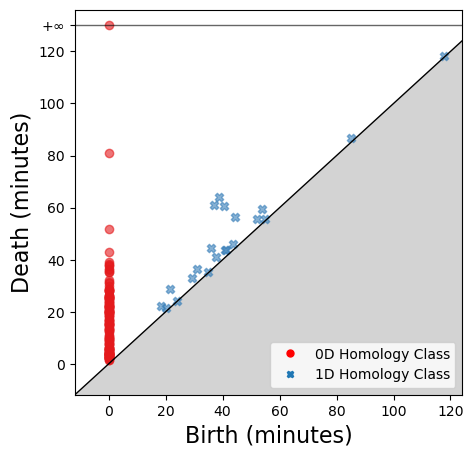

In [15]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

cpx, ph, all_pairs = get_tda_info(city_path, city_code, 1, \
                                  use_waits=False, time_units='min',dfilename=city_fname)
plt.rcParams['figure.figsize'] = (5, 5)

if False:
    for i, elt in enumerate(ph):
        ph[i] = (ph[i][0], (ph[i][1][0]/60, ph[i][1][1]/60))
    
myax=plot_persistence_diagram(ph,use_fixed_max=False)

red = mlines.Line2D([], [], color='red', marker='.', linestyle='None',
                          markersize=10, label='0D Homology Class')
blue = mlines.Line2D([], [], color='tab:blue', marker='X', linestyle='None',
                          markersize=5, label='1D Homology Class')
plt.legend(handles=[red, blue])
plt.title("")
plt.xlabel("Birth (minutes)")
plt.ylabel("Death (minutes)")
plt.savefig('./Dallas/Food access_updated/dal_tx_groc_PD.jpeg', bbox_inches="tight", dpi = 300)
plt.show()

In [16]:
# Geography files
# - why provide full path: we have multiple resources. 
# - ZIP codes make more sense to provide in "resource ID agnostic" location
pfname = './Dallas/Food access_updated/geo_export_872fcb6c-fbde-4264-ae77-8858a604ed0e.shp'
zipfname = './Dallas/dal_tx_zip.shp'

In [17]:
if False:
    for j in all_pairs:
        print(j, cpx.filtration(j[1])/60/60)

In [18]:
city_code

'dal'

In [19]:
# to equate to Barbara's data:
# 1 mi = 1609 m 
# 1609 m / 1.42 m/s / 60 s/min = # minutes to go one mile
# (ans) x 2 = minutes for round trip
abs_thresh = (1609/1.42/60)*2

In [20]:
abs_thresh_1mi=np.round(abs_thresh,1)

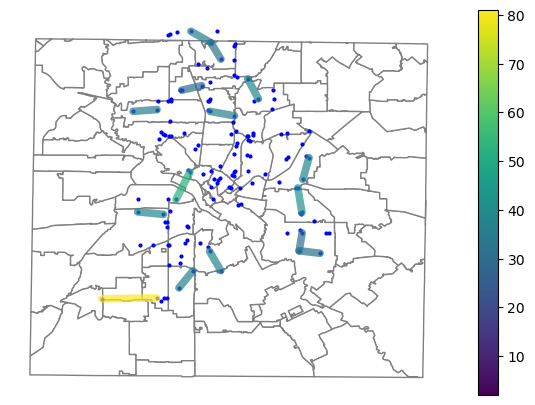

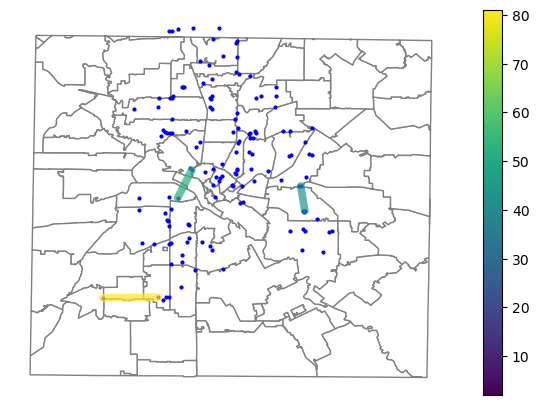

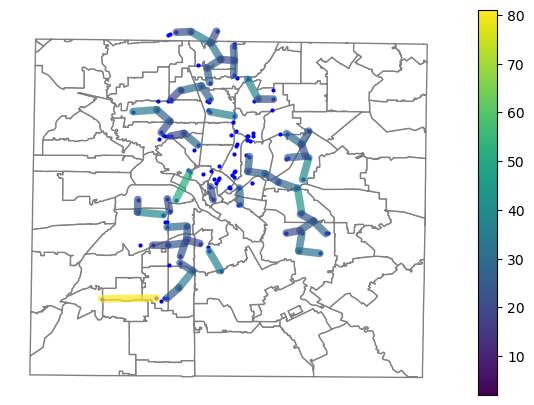

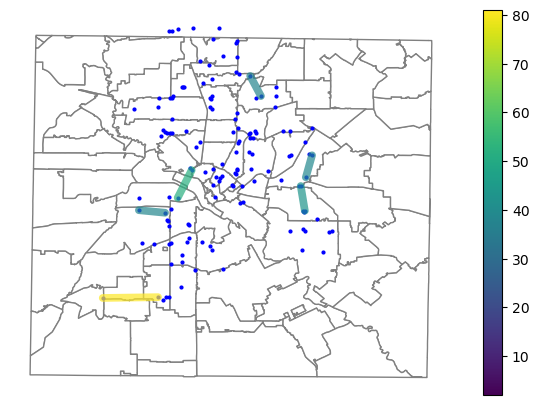

In [21]:
# H0
plt.rcParams['figure.figsize'] = (8,5)
fig, ax = plt.subplots(1,1)
order_criteria = 'death'
thresh = 1
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 0, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True,\
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_0_zscore_{thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

thresh = 2
fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 0, ax, \
                    criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname,legend=True, \
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_0_zscore_{thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

# 20 min round trip
abs_thresh = 20
fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 0, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True,\
                   use_abs_thresh=True, abs_thresh=abs_thresh, \
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_0_absth_{abs_thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

# 1 mi each way
fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 0, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True,\
                   use_abs_thresh=True, abs_thresh=abs_thresh_1mi, \
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_0_absth_{abs_thresh_1mi}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

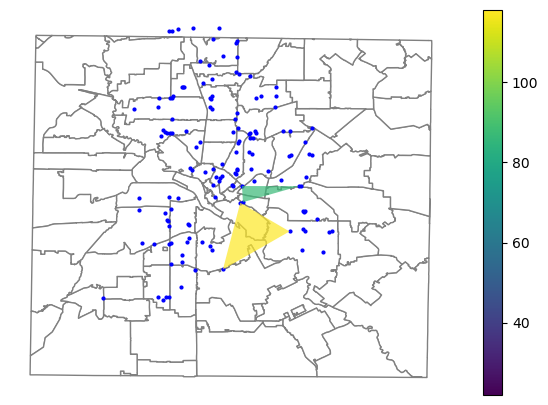

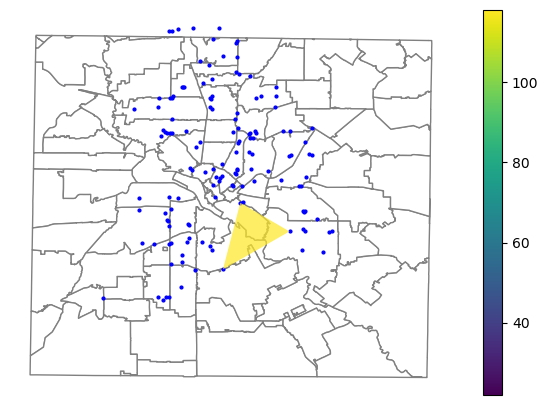

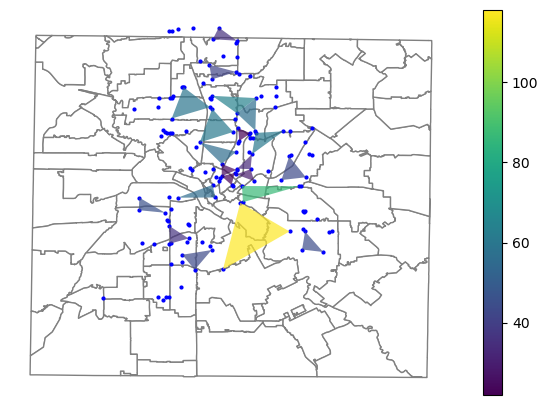

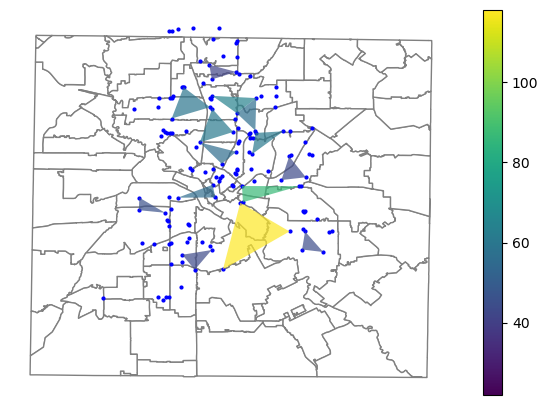

In [22]:
# H1
plt.rcParams['figure.figsize'] = (8,5)
fig, ax = plt.subplots(1,1)
order_criteria = 'death'
thresh = 1
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 1, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True, floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_1_zscore_{thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

thresh = 2
fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 1, ax, \
                    criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True, floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_1_zscore_{thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

# 20 min round trip
abs_thresh = 20
fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 1, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True,\
                   use_abs_thresh=True, abs_thresh=abs_thresh, \
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_1_absth_{abs_thresh}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

fig, ax = plt.subplots(1,1)
plot_deathsimplices(city_path, city_code, cpx, all_pairs, 1, \
                    ax, criteria = 'death', zscore_thresh = thresh, \
                   pfname = pfname, zipfname=zipfname, legend=True,\
                   use_abs_thresh=True, abs_thresh=abs_thresh_1mi, \
                   floatAxisLim=True)
plt.savefig(f'{city_path}/{city_code}_H_1_absth_{abs_thresh_1mi}_deathsimplices_by_{order_criteria}.jpeg', dpi = 300)
plt.show()

In [23]:
readDS=np.load('./Dallas/Food access_updated/dal_death_simplices_by_death_in_dim_0.npy', allow_pickle=True)

In [24]:
readDS[2][1]

43.053861898385684

In [25]:
readDS[2][2]

2.1674011490489478

Running on all cities

Colorbar generator